# Interpretación de resultados
Para organizar nuestro notebook (script), dedicaremos la celda inicial a la carga de librerías necesarias para la ejecución del script completo. Si necesitamos instalar algunas de ellas porque no estén disponibles en nuestro repositorio, las instalaremos y dejaremos indicado que hemos necesitado instalarlas. Esto servirá para la configuración del entorno de trabajo de futuros proyectos. :)

El notebook está esturcturado como sigue:

* Bloque A: carga del modelo entrenado.
* Bloque B: cálculo de los valores SHAP.
* Bloque C: visualización con `summary_plot`.

### Librerías

In [1]:
#install.packages("SHAPforxgboost")
#install.packages("Ckmeans.1d.dp")  -> caprichín para gráficos
#install.packages("patchwork")  -> caprichín para gráficos 

library(xgboost)   # la necesitamos para cargar el modelo entrenado
library(SHAPforxgboost)
library(ggplot2)
library(patchwork)

## BLOQUE A: carga del modelo entrenado

In [2]:
modelo <- xgb.load("modelo_entrenado")
data <- read.csv("dataPrepared.csv")
X <- subset(data, select=c('longitud.objetivo', 'tiempo.solido', 'quimico3', 'temperatura1', 'quimico4'))
y <- data$defecto

## BLOQUE B: importancia de los valores SHAP
Aunque los árboles de decisión pueden llegar a ser estimadores fácilmente interpretables, resulta muy complejo interpretar el modelo resultante al concatenar un buen número de ellos. Esto se debe a que, además de la elevada profundidad de cada árbol, existe un gran número de ellos, lo que hace imposible interpretar a simple vista el efecto que ejerce cada una de las variables.

Para interpretar este modelo se utilizará un método relativamente nuevo: **los valores SHAP** (_SHapley Additive exPlanation_). Se trata de un método que sirve sobre todo para explicar predicciones individuales basándose en los [valores de Shapley](https://es.wikipedia.org/wiki/Valor_de_Shapley) de la teoría de juegos. Estos valores de Shapley nos dicen como distribuir de manera justa los pesos o ponderaciones entre todas las variables en función a su contribución en la predicción. 

A continuación se incluyen algunos enlaces de interés:
* [Artículo](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) de Scott Lundberg con la presentación de la técnica.
* Página de [Github](https://github.com/slundberg/shap) que explica la librería de Python desarrollada por Scott Lundberg.  
* [Post en Medium](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3dv) con un ejemplo de cómo usar los valores SHAP para explicar la contribución de las variables en un modelo (ejemplo en Python).
* [Post](https://liuyanguu.github.io/post/2019/07/18/visualization-of-shap-for-xgboost/) con visualizaciones en R (`SHAPforxgboost` vignette). 

#### Cálculo de la importancia con `xgboost`
A continuación se ve el ranking de variables según las medidas `gain` y `frequency`.

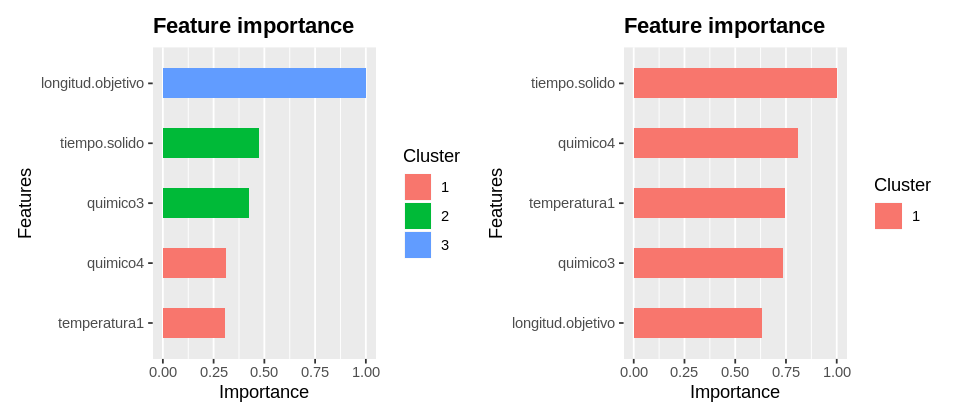

In [3]:
## Cáculo de la importancia de xgboost
options(repr.plot.width=8, repr.plot.height=3.5)
importance.matrix <- xgb.importance(names(X), model = modelo)
p1 <- xgb.ggplot.importance(importance.matrix, rel_to_first = TRUE, xlab = "Importancia relativa")
p2 <- xgb.ggplot.importance(importance.matrix, measure = 'Frequency', rel_to_first = TRUE, xlab = "Importancia relativa")
p1 + p2

#### Cálculo de los `SHAP values`
* 1. Utiliar la función `shap.values` para obtener los valores Shapley. ¿Qué tipo de objeto es? ¿Qué contiene?
* 2. ¿Qué dimensión debería tener `shap_score`?
* 3. ¿Qué es `mean_shap_score`?

In [6]:
# Obtener los SHAP values x
shap.values <- shap.values(xgb_model = modelo, X_train = X)
names(shap.values)
# Ranking de variables según mean |SHAP|
print(shap.values$mean_shap_score)

[1] "shap_score"      "mean_shap_score" "BIAS0"

longitud.objetivo     tiempo.solido          quimico3      temperatura1 
       0.16942821        0.09691637        0.08395768        0.07310690 
         quimico4 
       0.04478883 


Podemos comprobar que efectivamente, la suma de las filas de `shap.values` +`BIAS0` coincide con la salida del modelo: 

In [7]:
shap.data <- cbind(shap.values$shap_score, shap.values$BIAS0)
shap.sum <- rowSums(shap.data)
y_pred <- predict(modelo, as.matrix(X))

summary(round(shap.sum - y_pred),6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

## BLOQUE C: visualización de los valores SHAP
Aunque existen varias visualizaciones, utilizaremos la función `shap.plot.summary.wrap1` (variante de `shap.plot.summary`) para obtener una visión general:

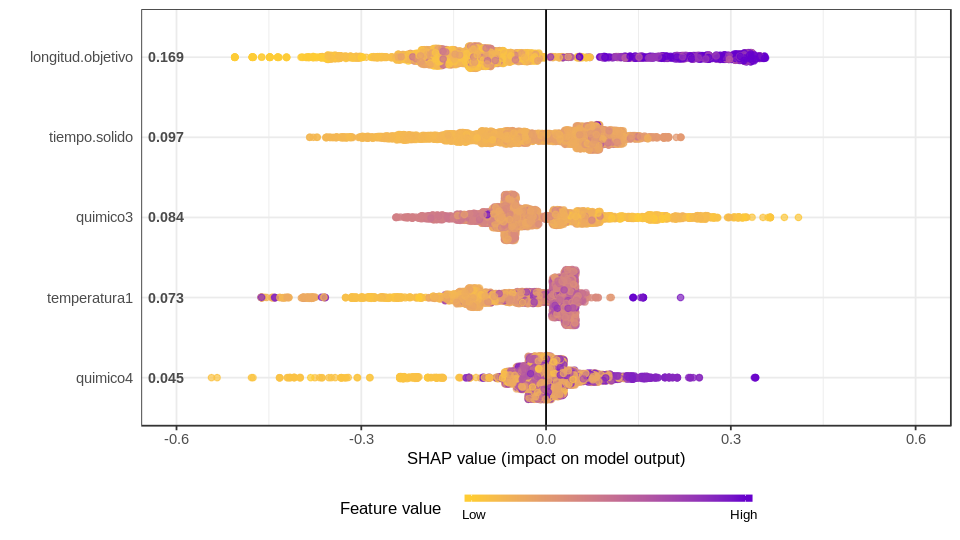

In [8]:
options(repr.plot.width=8, repr.plot.height=4.5)
shap.plot.summary.wrap1(modelo, X = X)

Podemos controlar algunos parámetros de la visualización como el límite en el eje X (con `x_bound`) o la proporción de observaciones a pintar (con `dilute`). Para ello, hay que usar la función `shap.plot.summary` y por tanto, hay que preparar los datos en el formato adecuado (`shap.prep`):

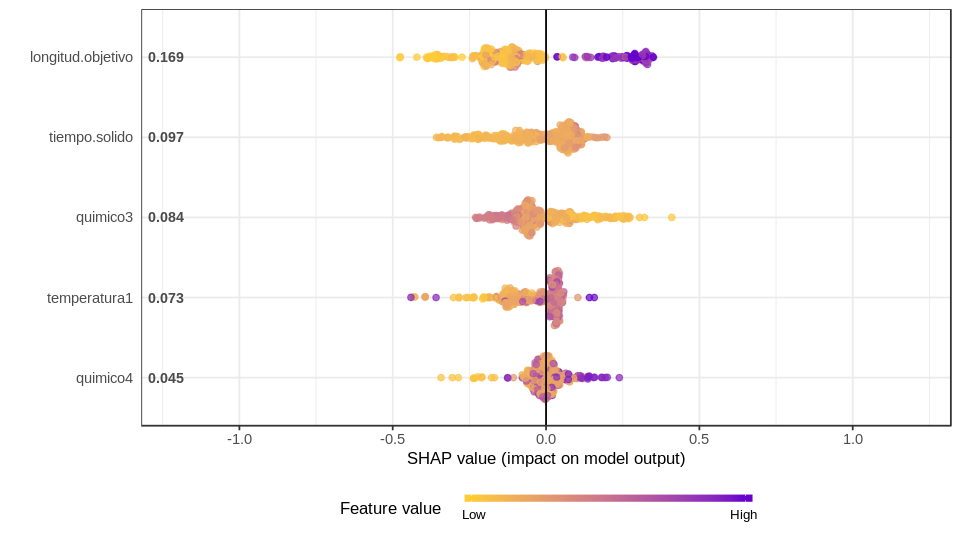

In [9]:
# Preparamos los datos en el formato que necesita
shap.long <- shap.prep(xgb_model = modelo, X_train = X)
shap.plot.summary(shap.long, x_bound  = 1.2, dilute = 10)